In [1]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import pickle 
import json

import dlc_bci as bci
from helpers import *

import numpy as np

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(1)
torch.set_num_threads(4)

%load_ext autoreload
%autoreload 2

### Importing the data

In [374]:
# Subset of data sampled at 100Hz
train_input , train_target = bci.load(root = './data_bci')
print("Train input :", str(type(train_input)), train_input.size()) 
print("Train target :", str(type(train_target)), train_target.size())
test_input , test_target = bci.load(root = './data_bci', train = False)
print("Test input :", str(type(test_input)), test_input.size()) 
print("Test target :", str(type(test_target)), test_target.size())

Train input : <class 'torch.FloatTensor'> torch.Size([316, 28, 50])
Train target : <class 'torch.LongTensor'> torch.Size([316])
Test input : <class 'torch.FloatTensor'> torch.Size([100, 28, 50])
Test target : <class 'torch.LongTensor'> torch.Size([100])


In [2]:
# Full data sampled at 1Khz
train_input , train_target = bci.load(root = './data_bci', one_khz = True)
print("Train input :", str(type(train_input)), train_input.size()) 
print("Train target :", str(type(train_target)), train_target.size())
test_input , test_target = bci.load(root = './data_bci', train = False, one_khz = True)
print("Test input :", str(type(test_input)), test_input.size()) 
print("Test target :", str(type(test_target)), test_target.size())

Train input : <class 'torch.FloatTensor'> torch.Size([316, 28, 500])
Train target : <class 'torch.LongTensor'> torch.Size([316])
Test input : <class 'torch.FloatTensor'> torch.Size([100, 28, 500])
Test target : <class 'torch.LongTensor'> torch.Size([100])


In [3]:
train_input[0]


  30.8000   33.1000   37.9000  ...    76.9000   75.9000   72.3000
 -22.6000  -19.2000  -11.8000  ...    26.8000   22.9000   16.4000
  11.2000   16.7000   26.4000  ...    64.1000   62.0000   55.9000
             ...                ⋱                ...             
   0.5000    0.5000    0.4000  ...    45.1000   46.2000   46.6000
  11.0000   10.6000    9.8000  ...    41.7000   41.5000   40.9000
  -9.9000  -10.0000  -10.3000  ...    32.9000   33.8000   32.8000
[torch.FloatTensor of size 28x500]

In [4]:
train_target


 0
 1
 0
 1
 0
 1
 0
 1
 0
 0
 1
 1
 0
 0
 1
 1
 1
 0
 0
 1
 0
 0
 1
 0
 1
 0
 0
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 0
 1
 0
 1
 0
 0
 1
 0
 1
 1
 0
 1
 1
 0
 0
 1
 0
 0
 1
 0
 1
 0
 1
 0
 0
 1
 0
 0
 0
 0
 0
 1
 0
 1
 0
 0
 0
 0
 0
 1
 1
 1
 0
 1
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 0
 0
 0
 0
 1
 1
 1
 0
 1
 1
 1
 0
 1
 0
 1
 1
 1
 0
 1
 0
 1
 0
 0
 0
 1
 0
 0
 1
 1
 1
 1
 0
 1
 1
 0
 0
 1
 1
 1
 1
 1
 0
 0
 0
 0
 1
 1
 0
 1
 1
 1
 1
 1
 1
 1
 0
 0
 0
 1
 1
 0
 0
 1
 1
 0
 0
 0
 0
 0
 1
 1
 1
 1
 1
 1
 0
 1
 0
 1
 1
 0
 1
 0
 0
 1
 1
 1
 0
 0
 1
 0
 0
 0
 0
 0
 1
 1
 0
 0
 0
 0
 1
 0
 0
 0
 1
 0
 0
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0
 1
 1
 1
 0
 0
 0
 1
 0
 1
 1
 1
 1
 1
 1
 1
 0
 1
 0
 0
 0
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0
 0
 1
 1
 0
 1
 1
 0
 1
 1
 1
 1
 1
 0
 1
 0
 1
 0
 0
 0
 0
 0
 0
 1
 1
 1
 0
 1
 1
 1
 0
 1
 0
 0
 1
 1
 0
 0
 1
 0
 0
 1
 0
 0
 0
 1
 0
 0
 1
 1
 0
 0
 1
 1
 1
 0
 1
 0
 1
 1
 1
 0
 1
 1
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 316]

### Preprocessing the data
Normalizing :

In [5]:
train_mean = train_input.mean(2).mean(0).unsqueeze(1).expand(-1,train_input.size(2))
train_std = train_input.std(2).std(0).unsqueeze(1).expand(-1,train_input.size(2))

In [6]:
test_mean = test_input.mean(2).mean(0).unsqueeze(1).expand(-1,test_input.size(2))
test_std = test_input.std(2).std(0).unsqueeze(1).expand(-1,test_input.size(2))

In [7]:
# normalize mean to 0
train_input.sub_(train_mean)
test_input.sub_(test_mean)

# normalize variance to 1
train_input.div_(train_input.std())
test_input.div_(test_input.std())

print('done')

done


Window slicing for data augmentation :

In [8]:
seq = [ train_input[:,:,i::10] for i in range(10) ]
train_input = torch.cat(seq)

In [9]:
train_target = torch.cat([train_target]*10)

In [10]:
seq = [ test_input[:,:,i::10] for i in range(10) ]
test_input = torch.cat(seq)

In [11]:
test_target = torch.cat([test_target]*10)

In [12]:
train_input


( 0  ,.,.) = 
 -1.1184e+00 -6.6277e-01 -1.1995e+00  ...   4.5434e-01 -2.1655e-01  3.7009e-01
 -6.8330e-01  7.6446e-05 -7.4883e-01  ...   1.0049e+00  8.7448e-02  1.0891e+00
 -1.1344e+00 -6.4085e-02 -1.1812e+00  ...   9.9686e-01 -3.5741e-01  1.2122e+00
                 ...                   ⋱                   ...                
 -3.4267e-01 -2.2721e-01 -7.1193e-02  ...   8.4621e-01  8.3997e-01  7.6820e-01
 -3.7571e-01 -1.5416e-01  2.5774e-01  ...   9.5359e-01  9.5359e-01  6.4467e-01
 -5.9022e-01 -3.2186e-01 -5.3502e-02  ...   8.7327e-01  8.9511e-01  6.1739e-01

( 1  ,.,.) = 
  2.1550e+00  2.1269e+00  2.4670e+00  ...   3.4825e-01  7.7262e-01  5.7604e-01
  5.4927e-01  4.3762e-02  6.2416e-01  ...  -1.2356e+00 -3.5877e-01 -1.0234e+00
 -7.3810e-01 -1.1999e+00 -7.4434e-01  ...  -2.0424e+00 -1.2623e+00 -1.8958e+00
                 ...                   ⋱                   ...                
 -9.4491e-01 -8.7938e-01 -1.2351e+00  ...  -1.3225e+00 -9.8548e-01 -8.4194e-01
 -5.2861e-01 -5.3797e-

Splitting training and validation sets :

In [13]:
split = 2500

In [14]:
indices = np.arange(train_input.size(0))
np.random.shuffle(indices)

In [15]:
full_input = train_input.clone()
train_input = full_input[indices[:split].tolist()]
validation_input = full_input[indices[split:].tolist()]

In [16]:
full_target = train_target.clone()
train_target = full_target[indices[:split].tolist()]
validation_target = full_target[indices[split:].tolist()]

## Linear Regression

In [164]:
from sklearn.linear_model import LinearRegression

In [165]:
linear_reg = LinearRegression()

In [166]:
linear_reg.fit(train_input.view(train_input.size(0),-1),train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [167]:
linear_pred_train = discrete_predictions(torch.FloatTensor(linear_reg.predict(train_input.view(train_input.size(0),-1))))

In [168]:
print(100*((linear_pred_train - train_target).abs().sum()/train_input.size(0)),"% train error")

0.0 % train error


In [169]:
linear_pred_test = discrete_predictions(torch.FloatTensor(linear_reg.predict(test_input.view(test_input.size(0),-1))))

In [170]:
print(100*((linear_pred_test - test_target).abs().sum()/test_input.size(0)),"% test error")

34.9 % test error


## Ridge Regression

In [171]:
from sklearn.linear_model import Ridge

In [172]:
ridge_reg = Ridge()

In [173]:
ridge_reg.fit(train_input.view(train_input.size(0),-1),train_target)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [174]:
ridge_pred_train = discrete_predictions(torch.FloatTensor(ridge_reg.predict(train_input.view(train_input.size(0),-1))))

In [175]:
print(100*((ridge_pred_train - train_target).abs().sum()/train_input.size(0)),"% train error")

0.0 % train error


In [176]:
ridge_pred_test = discrete_predictions(torch.FloatTensor(ridge_reg.predict(test_input.view(test_input.size(0),-1))))

In [177]:
print(100*((ridge_pred_test - test_target).abs().sum()/test_input.size(0)),"% test error")

34.9 % test error


## Logistic Regression

In [152]:
from sklearn.linear_model import LogisticRegression

In [153]:
logistic_reg = LogisticRegression()

In [154]:
logistic_reg.fit(train_input.view(train_input.size(0),-1),train_target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [155]:
logistic_pred_train = torch.LongTensor(logistic_reg.predict(train_input.view(train_input.size(0),-1)))

In [156]:
print(100*((logistic_pred_train - train_target).abs().sum()/train_input.size(0)),"% train error")

0.0 % train error


In [157]:
logistic_pred_test = logistic_reg.predict(test_input.view(test_input.size(0),-1))

In [158]:
print(100*((logistic_pred_test - test_target).abs().sum()/test_input.size(0)),"% test error")

28.000000000000004 % test error


## Neural Networks

### Basic MLP

In [17]:
MLP = nn.Sequential(
        nn.Linear(1400, 140),
        nn.Tanh(),
        nn.Linear(140, 28),
        nn.Tanh(),
        nn.Linear(28, 2)
    )

In [19]:
train_model(MLP, Variable(full_input.view(full_input.size(0),-1)), Variable(full_target), 40)

Epoch 1 loss = 44.072047382593155
Epoch 10 loss = 9.844592585228384
Epoch 20 loss = 6.37521896418184
Epoch 30 loss = 0.04982630047015846
Epoch 40 loss = 0.01820115691953106
Epoch 50 loss = 0.009272573479393031
Epoch 60 loss = 0.00532340435529477
Epoch 70 loss = 0.0032243903369817417
Epoch 80 loss = 0.0020220179230818758
Epoch 90 loss = 0.0012823412580473814
Epoch 100 loss = 0.0008373723703698488


In [28]:
train_error_mlp = compute_nb_errors(MLP, Variable(full_input.view(full_input.size(0),-1)), Variable(full_target))
print(100*(train_error_mlp/full_input.size(0)),'% training error')

0.0 % training error


In [29]:
test_error_mlp = compute_nb_errors(MLP, Variable(test_input.view(test_input.size(0),-1)), Variable(test_target))
print(100*(test_error_mlp/test_input.size(0)),'% test error')

40.5 % test error


### Basic CNN

In [60]:
class Basic_CNN(nn.Module):
    def __init__(self):
        super(Basic_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3)
        self.fc1 = nn.Linear(128, 28)
        self.fc2 = nn.Linear(28, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.tanh(F.max_pool2d(self.conv2(x), kernel_size=(3,2), stride=(3,2)))
        x = F.tanh(self.conv3(x))
        x = F.tanh(self.fc1(x.view(x.size(0),-1)))
        x = self.fc2(x)
        return x

In [56]:
cnn = Basic_CNN()

In [ ]:
train_model(cnn, Variable(full_input.unsqueeze(1)), Variable(full_target), 40)

In [30]:
train_error_cnn = compute_nb_errors(cnn, Variable(full_input.unsqueeze(1)), Variable(full_target))
print(100*(train_error_cnn/full_input.size(0)),'% training error')

0.0 % training error


In [31]:
test_error_cnn = compute_nb_errors(cnn, Variable(test_input.unsqueeze(1)), Variable(test_target))
print(100*(test_error_cnn/test_input.size(0)),'% test error')

38.4 % test error


### CNN w 1D filters

In [39]:
class CNN_1D(nn.Module):
    def __init__(self):
        super(CNN_1D, self).__init__()
        self.conv1 = nn.Conv1d(28, 28, kernel_size=3)
        self.conv2 = nn.Conv1d(28, 14, kernel_size=3)
        self.conv3 = nn.Conv1d(14, 1, kernel_size=3)
        self.fc1 = nn.Linear(9, 36)
        self.fc2 = nn.Linear(36, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.tanh(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        x = F.tanh(self.conv3(x))
        x = self.fc1(x.squeeze(1))
        x = self.fc2(F.tanh(x))
        return x

In [33]:
cnn_1D = CNN_1D()
train_model(cnn_1D, Variable(full_input), Variable(full_target), 40)

Epoch 1 loss = 52.112239360809326
Epoch 10 loss = 6.469338921830058
Epoch 20 loss = 0.2049055152456276
Epoch 30 loss = 0.04752383720187936
Epoch 40 loss = 0.019488050551444758
Epoch 50 loss = 0.009714462295960402
Epoch 60 loss = 0.0053200298571027815
Epoch 70 loss = 0.003074018642109877
Epoch 80 loss = 0.0018293963439646177
Epoch 90 loss = 0.0011096503940279945
Epoch 100 loss = 0.0006824515285188681


In [34]:
train_error_cnn_1D = compute_nb_errors(cnn_1D, Variable(full_input), Variable(full_target))
print(100*(train_error_cnn_1D/full_input.size(0)),'% training error')

0.0 % training error


In [35]:
test_error_cnn_1D = compute_nb_errors(cnn_1D, Variable(test_input), Variable(test_target))
print(100*(test_error_cnn_1D/test_input.size(0)),'% test error')

20.8 % test error


### previous + dropout

In [40]:
class CNN_dropout(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN_dropout, self).__init__()
        self.conv1 = nn.Conv1d(28, 28, kernel_size=3)
        self.conv2 = nn.Conv1d(28, 14, kernel_size=3)
        self.conv3 = nn.Conv1d(14, 1, kernel_size=3)
        self.fc1 = nn.Linear(9, 30)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(30, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool1d(self.conv1(x), kernel_size=2, stride=2))
        x = F.tanh(F.max_pool1d(self.conv2(x), kernel_size=2, stride=2))
        x = F.tanh(self.conv3(x))
        x = self.fc1(x.squeeze(1))
        x = self.dropout(x)
        x = self.fc2(F.tanh(x))
        return x

In [39]:
cnn_drop = CNN_dropout()
train_model(cnn_drop, Variable(full_input), Variable(full_target), 40)

Epoch 1 loss = 54.21390461921692
Epoch 10 loss = 13.391567431390285
Epoch 20 loss = 0.602470112266019
Epoch 30 loss = 0.16750079122721218
Epoch 40 loss = 0.073359655601962
Epoch 50 loss = 0.03508611716097221
Epoch 60 loss = 0.030605764273786917
Epoch 70 loss = 0.10801360759069212
Epoch 80 loss = 0.04040353424352361
Epoch 90 loss = 0.01755940921975707
Epoch 100 loss = 0.01218668266574241


In [44]:
train_error_cnn_drop = compute_nb_errors(cnn_drop, Variable(full_input), Variable(full_target))
print(100*(train_error_cnn_drop/full_input.size(0)),'% training error')

0.0 % training error


In [41]:
test_error_cnn_drop = compute_nb_errors(cnn_drop, Variable(test_input), Variable(test_target))
print(100*(test_error_cnn_drop/test_input.size(0)),'% test error')

24.3 % test error


## Batch normalization

In [41]:
class CNN_batchnorm(nn.Module):
    def __init__(self):
        super(CNN_batchnorm, self).__init__()
        self.conv1 = nn.Conv1d(28, 28, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(28)
        self.conv2 = nn.Conv1d(28, 14, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(14)
        self.conv3 = nn.Conv1d(14, 1, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(1)
        self.fc1 = nn.Linear(9, 30)
        self.bn4 = nn.BatchNorm1d(30)
        self.fc2 = nn.Linear(30, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool1d(self.bn1(self.conv1(x)), kernel_size=2, stride=2))
        x = F.tanh(F.max_pool1d(self.bn2(self.conv2(x)), kernel_size=2, stride=2))
        x = F.tanh(self.bn3(self.conv3(x)))
        x = self.fc1(x.squeeze(1))
        x = self.fc2(F.tanh(self.bn4(x)))
        return x

In [45]:
cnn_norm = CNN_batchnorm()
train_model(cnn_norm, Variable(full_input), Variable(full_target), 40)

Epoch 1 loss = 49.73396196961403
Epoch 10 loss = 2.693355151452124
Epoch 20 loss = 0.20191391304251738
Epoch 30 loss = 0.026976141351042315
Epoch 40 loss = 0.013303212912433082
Epoch 50 loss = 0.007391592858766671
Epoch 60 loss = 0.0043405275700934
Epoch 70 loss = 0.0026283940233042813
Epoch 80 loss = 0.0016277259023809165
Epoch 90 loss = 0.0010235974186798558
Epoch 100 loss = 0.0006506333036213618


In [46]:
train_error_cnn_norm = compute_nb_errors(cnn_norm, Variable(full_input), Variable(full_target))
print(100*(train_error_cnn_norm/full_input.size(0)),'% training error')

0.03164556962025317 % training error


In [47]:
test_error_cnn_norm = compute_nb_errors(cnn_norm, Variable(test_input), Variable(test_target))
print(100*(test_error_cnn_norm/test_input.size(0)),'% test error')

24.7 % test error


## Both dropout and batchnorm

In [42]:
class CNN_both(nn.Module):
    def __init__(self, dropout=0.5):
        super(CNN_both, self).__init__()
        self.conv1 = nn.Conv1d(28, 28, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(28)
        self.conv2 = nn.Conv1d(28, 14, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(14)
        self.conv3 = nn.Conv1d(14, 1, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(1)
        self.fc1 = nn.Linear(9, 30)
        self.bn4 = nn.BatchNorm1d(30)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(30, 2)

    def forward(self, x):
        x = F.tanh(F.max_pool1d(self.bn1(self.conv1(x)), kernel_size=2, stride=2))
        x = F.tanh(F.max_pool1d(self.bn2(self.conv2(x)), kernel_size=2, stride=2))
        x = F.tanh(self.bn3(self.conv3(x)))
        x = self.fc1(x.squeeze(1))
        x = self.dropout(self.bn4(x))
        x = self.fc2(F.tanh(x))
        return x

In [49]:
cnn_both = CNN_both()
train_model(cnn_both, Variable(full_input), Variable(full_target), 40)

Epoch 1 loss = 53.4827983379364
Epoch 10 loss = 3.010024955496192
Epoch 20 loss = 0.169668891641777
Epoch 30 loss = 4.367536114295945
Epoch 40 loss = 0.0749251453235047
Epoch 50 loss = 0.03644149238243699
Epoch 60 loss = 0.019753706072151545
Epoch 70 loss = 0.014550293459251407
Epoch 80 loss = 1.8616079927887768
Epoch 90 loss = 0.082001906062942
Epoch 100 loss = 0.03303353711817181


In [50]:
train_error_cnn_both = compute_nb_errors(cnn_both, Variable(full_input), Variable(full_target))
print(100*(train_error_cnn_both/full_input.size(0)),'% training error')

0.06329113924050633 % training error


In [51]:
test_error_cnn_both = compute_nb_errors(cnn_both, Variable(test_input), Variable(test_target))
print(100*(test_error_cnn_both/test_input.size(0)),'% test error')

26.700000000000003 % test error


## Grid search

In [64]:
def find_best_params(network, train_input, train_target, val_input, val_target, learning_rates, nb_epochs_total, epoch_step, mini_batch_size):
    res = []
    best_error = val_input.size(0)+1
    #print("MLP")
    print("MODEL", network().__class__.__name__)
    print("="*18)
    for lr in learning_rates: 
        print("  Learning rate", lr, ":")
        print("-"*23)
        epoch_acc = []
        model = network()
        #model = nn.Sequential(
        #    nn.Linear(1400, 140),
        #    nn.Tanh(),
        #    nn.Linear(140, 28),
        #    nn.Tanh(),
        #    nn.Linear(28, 2)
        #)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for e in range(nb_epochs_total):
            sum_loss = 0
            model.train()
            for b in range(0, train_input.size(0), mini_batch_size):
                output = model(train_input.narrow(0, b, mini_batch_size))
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
                sum_loss = sum_loss + loss.data[0]
                model.zero_grad()
                loss.backward()
                optimizer.step()
                
            if (e+1)%epoch_step == 0 or e==0:
                validation_error = compute_nb_errors(model, val_input, val_target)
                if (e+1)%(10*epoch_step) == 0 or e==0:
                    print("    Epoch {:>4} : loss = {:1.8f} | validation error = {:>4}".format(e+1, sum_loss, validation_error))
                epoch_acc.append(100*(validation_error/val_input.size(0)))
                if (validation_error < best_error) or ( (validation_error == best_error) and ((e+1) < best_epoch) ):
                    best_error = validation_error
                    best_epoch = e+1
                    best_lr = lr
                    
        res.append(epoch_acc)
    print("Done.")
    return res, best_epoch, best_lr, best_error

MLP test :

In [33]:
learning_rates = [0.001, 0.0025, 0.005, 0.0075, 0.01]
nb_epochs_total = 500
epoch_step = 5
mini_batch_size = 250

In [34]:
all_results, best_epoch, best_lr, best_error = find_best_params(MLP, Variable(train_input.view(train_input.size(0),-1)), Variable(train_target), Variable(validation_input.view(validation_input.size(0),-1)), Variable(validation_target), learning_rates, nb_epochs_total, epoch_step, mini_batch_size)
json_res = {"model":"MLP",   "learning_rates":learning_rates, "nb_epochs_total":nb_epochs_total, "epoch_step":epoch_step, "mini_batch_size":mini_batch_size, "best_epoch":best_epoch, "best_lr":best_lr, "best_error":best_error, "results":all_results}
json.dump(json_res,open('results/adam/'+json_res["model"]+'.json','w'))

MLP
  Learning rate 0.001 :
-----------------------
    Epoch    1 : loss = 6.72939926 | validation error =  238
    Epoch   50 : loss = 0.02746910 | validation error =    0
    Epoch  100 : loss = 0.00958435 | validation error =    0
    Epoch  150 : loss = 0.00356965 | validation error =    0
    Epoch  200 : loss = 0.00183774 | validation error =    0
    Epoch  250 : loss = 0.00113654 | validation error =    0
    Epoch  300 : loss = 0.00075911 | validation error =    0
    Epoch  350 : loss = 0.00052780 | validation error =    0
    Epoch  400 : loss = 0.00037670 | validation error =    0
    Epoch  450 : loss = 0.00027348 | validation error =    0
    Epoch  500 : loss = 0.00020099 | validation error =    0
  Learning rate 0.0025 :
-----------------------
    Epoch    1 : loss = 6.78789276 | validation error =  208
    Epoch   50 : loss = 0.02694813 | validation error =    0
    Epoch  100 : loss = 0.00219738 | validation error =    0
    Epoch  150 : loss = 0.00103722 | validati

Basic CNN test :

In [65]:
learning_rates = [0.001, 0.0025, 0.005, 0.0075, 0.01]
nb_epochs_total = 100
epoch_step = 5
mini_batch_size = 250

In [66]:
all_results, best_epoch, best_lr, best_error = find_best_params(Basic_CNN, Variable(train_input.unsqueeze(1)), Variable(train_target), Variable(validation_input.unsqueeze(1)), Variable(validation_target), learning_rates, nb_epochs_total, epoch_step, mini_batch_size)
json_res = {"model":"Basic_CNN",   "learning_rates":learning_rates, "nb_epochs_total":nb_epochs_total, "epoch_step":epoch_step, "mini_batch_size":mini_batch_size, "best_epoch":best_epoch, "best_lr":best_lr, "best_error":best_error, "results":all_results}
json.dump(json_res,open('results/adam/'+json_res["model"]+'.json','w'))

MODEL Basic_CNN
  Learning rate 0.001 :
-----------------------
    Epoch    1 : loss = 6.93463784 | validation error =  288
    Epoch   50 : loss = 0.01172235 | validation error =    0
    Epoch  100 : loss = 0.00257484 | validation error =    0
  Learning rate 0.0025 :
-----------------------
    Epoch    1 : loss = 6.93030840 | validation error =  302
    Epoch   50 : loss = 0.00179214 | validation error =    0
    Epoch  100 : loss = 0.00050704 | validation error =    0
  Learning rate 0.005 :
-----------------------
    Epoch    1 : loss = 6.87247020 | validation error =  280
    Epoch   50 : loss = 0.00050149 | validation error =    3
    Epoch  100 : loss = 0.00016828 | validation error =    3
  Learning rate 0.0075 :
-----------------------
    Epoch    1 : loss = 7.09767592 | validation error =  338
    Epoch   50 : loss = 0.00077433 | validation error =    0
    Epoch  100 : loss = 0.00025720 | validation error =    0
  Learning rate 0.01 :
-----------------------
    Epoch  

NameError: name 'm' is not defined

All the 4 other models :

In [144]:
learning_rates = [0.001, 0.0025, 0.005, 0.0075, 0.01]
nb_epochs_total = 2000
epoch_step = 10
mini_batch_size = 250

models = [ CNN_1D, CNN_dropout, CNN_batchnorm, CNN_both ]

In [146]:
for m in models:
    all_results, best_epoch, best_lr, best_error = find_best_params(m, Variable(train_input), Variable(train_target), Variable(validation_input), Variable(validation_target), learning_rates, nb_epochs_total, epoch_step, mini_batch_size)
    print("")
    json_res = {"model":m().__class__.__name__,   "learning_rates":learning_rates, "nb_epochs_total":nb_epochs_total, "epoch_step":epoch_step, "mini_batch_size":mini_batch_size, "best_epoch":best_epoch, "best_lr":best_lr, "best_error":best_error, "results":all_results}
    json.dump(json_res,open('results/adam/'+json_res["model"]+'.json','w'))

MODEL CNN_1D
  Learning rate 0.001 :
-----------------------
    Epoch    1 : loss = 6.90667015 | validation error =  268
    Epoch  100 : loss = 0.02529639 | validation error =    3
    Epoch  200 : loss = 0.02296719 | validation error =    4
    Epoch  300 : loss = 0.00402738 | validation error =    2
    Epoch  400 : loss = 0.00167221 | validation error =    2
    Epoch  500 : loss = 0.00081492 | validation error =    2
    Epoch  600 : loss = 0.00042553 | validation error =    1
    Epoch  700 : loss = 0.00023059 | validation error =    1
    Epoch  800 : loss = 0.00012739 | validation error =    1
    Epoch  900 : loss = 0.00007127 | validation error =    1
    Epoch 1000 : loss = 0.00004026 | validation error =    1
    Epoch 1100 : loss = 0.00002287 | validation error =    1
    Epoch 1200 : loss = 0.00001305 | validation error =    1
    Epoch 1300 : loss = 0.00000747 | validation error =    1
    Epoch 1400 : loss = 0.00000429 | validation error =    1
    Epoch 1500 : loss = 

    Epoch  200 : loss = 0.00156475 | validation error =    3
    Epoch  300 : loss = 0.00070534 | validation error =    2
    Epoch  400 : loss = 0.00025862 | validation error =    2
    Epoch  500 : loss = 0.16858541 | validation error =    5
    Epoch  600 : loss = 0.00899296 | validation error =    1
    Epoch  700 : loss = 0.00444982 | validation error =    1
    Epoch  800 : loss = 0.00167385 | validation error =    1
    Epoch  900 : loss = 0.00101449 | validation error =    2
    Epoch 1000 : loss = 0.01350705 | validation error =    1
    Epoch 1100 : loss = 0.00333197 | validation error =    1
    Epoch 1200 : loss = 0.00142907 | validation error =    1
    Epoch 1300 : loss = 0.00085913 | validation error =    1
    Epoch 1400 : loss = 0.00048945 | validation error =    1
    Epoch 1500 : loss = 0.00020497 | validation error =    1
    Epoch 1600 : loss = 0.00764812 | validation error =    2
    Epoch 1700 : loss = 0.00250055 | validation error =    1
    Epoch 1800 : loss = 

    Epoch  500 : loss = 0.00001286 | validation error =    1
    Epoch  600 : loss = 0.00000692 | validation error =    1
    Epoch  700 : loss = 0.00000383 | validation error =    1
    Epoch  800 : loss = 0.00000216 | validation error =    1
    Epoch  900 : loss = 0.00000124 | validation error =    1
    Epoch 1000 : loss = 0.00000071 | validation error =    1
    Epoch 1100 : loss = 0.00000041 | validation error =    1
    Epoch 1200 : loss = 0.00000024 | validation error =    1
    Epoch 1300 : loss = 0.00000014 | validation error =    1
    Epoch 1400 : loss = 0.00000008 | validation error =    1
    Epoch 1500 : loss = 0.00000005 | validation error =    1
    Epoch 1600 : loss = 0.00000003 | validation error =    1
    Epoch 1700 : loss = 0.00000002 | validation error =    1
    Epoch 1800 : loss = 0.00000001 | validation error =    1
    Epoch 1900 : loss = 0.00000001 | validation error =    1
    Epoch 2000 : loss = 0.00000000 | validation error =    1
  Learning rate 0.0075 :

    Epoch  800 : loss = 0.00001973 | validation error =    2
    Epoch  900 : loss = 0.00002339 | validation error =    2
    Epoch 1000 : loss = 0.00007515 | validation error =    1
    Epoch 1100 : loss = 0.00780443 | validation error =    2
    Epoch 1200 : loss = 0.00321243 | validation error =    4
    Epoch 1300 : loss = 0.00094258 | validation error =    3
    Epoch 1400 : loss = 2.78687574 | validation error =   68
    Epoch 1500 : loss = 0.00386805 | validation error =    3
    Epoch 1600 : loss = 0.00218911 | validation error =    4
    Epoch 1700 : loss = 0.00031840 | validation error =    2
    Epoch 1800 : loss = 0.00025525 | validation error =    2
    Epoch 1900 : loss = 0.00024211 | validation error =    3
    Epoch 2000 : loss = 0.00002352 | validation error =    1
  Learning rate 0.01 :
-----------------------
    Epoch    1 : loss = 6.68809742 | validation error =  318
    Epoch  100 : loss = 0.00085660 | validation error =    1
    Epoch  200 : loss = 0.00031577 | v

In [ ]:
# correct each one

Test results :

In [148]:
error_rates = []
for m in models:
    model = m()
    json_res = json.load(open('results/adam/'+model.__class__.__name__+'.json','r'))
    print(json_res["model"])
    print("For", json_res['best_epoch'], "epochs, with a learning rate of", json_res['best_lr'])
    train_model(model, Variable(train_input), Variable(train_target), json_res['mini_batch_size'], nb_epochs=json_res['best_epoch'], learning_rate=json_res['best_lr'], verbose=False)
    test_error = compute_nb_errors(model, Variable(test_input), Variable(test_target))
    print(100*(test_error/test_input.size(0)))
    error_rates.append(100*(test_error/test_input.size(0)))
    print("="*10)

CNN_1D
For 960 epochs, with a learning rate of 0.0025
23.1
CNN_dropout
For 1220 epochs, with a learning rate of 0.001
21.3
CNN_batchnorm
For 170 epochs, with a learning rate of 0.0025
23.7
CNN_both
For 100 epochs, with a learning rate of 0.005
27.0


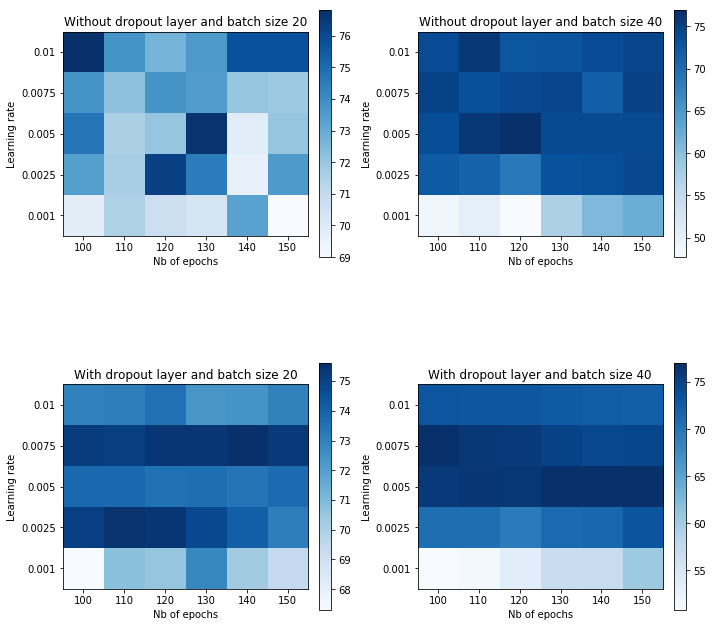

In [281]:
plt.figure(1)

colormap = 'Blues'
normal_xticks = normal_results['nb_epochs']
normal_yticks = normal_results['learning_rates']

plt.subplot(221)
plt.imshow(np.array(normal_results['results'][0]).T, cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(normal_xticks)), normal_xticks)
plt.yticks(range(len(normal_yticks)), normal_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Without dropout layer and batch size 20')

plt.subplot(222)
plt.imshow(np.array(normal_results['results'][1]).T, cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(normal_xticks)), normal_xticks)
plt.yticks(range(len(normal_yticks)), normal_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Without dropout layer and batch size 40')

dropout_xticks = dropout_results['nb_epochs']
dropout_yticks = dropout_results['learning_rates']

plt.subplot(223)
plt.imshow(dropout_results['results'][0], cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(dropout_xticks)), dropout_xticks)
plt.yticks(range(len(dropout_yticks)), dropout_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('With dropout layer and batch size 20')

plt.subplot(224)
plt.imshow(dropout_results['results'][1], cmap=colormap)
plt.xlabel('Nb of epochs')
plt.ylabel('Learning rate')
plt.xticks(range(len(dropout_xticks)), dropout_xticks)
plt.yticks(range(len(dropout_yticks)), dropout_yticks)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('With dropout layer and batch size 40')

plt.tight_layout()
plt.savefig("results_1.png")
plt.show()